Linear Regression: RMSE=0.0002, MAE=0.0001, R^2=1.0000
Decision Tree: RMSE=0.6176, MAE=0.2567, R^2=0.2608
Random Forest: RMSE=0.5658, MAE=0.2223, R^2=0.3794
Best Random Forest Params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 100}
Tuned Random Forest: RMSE=0.5979, MAE=0.2359, R^2=0.3070


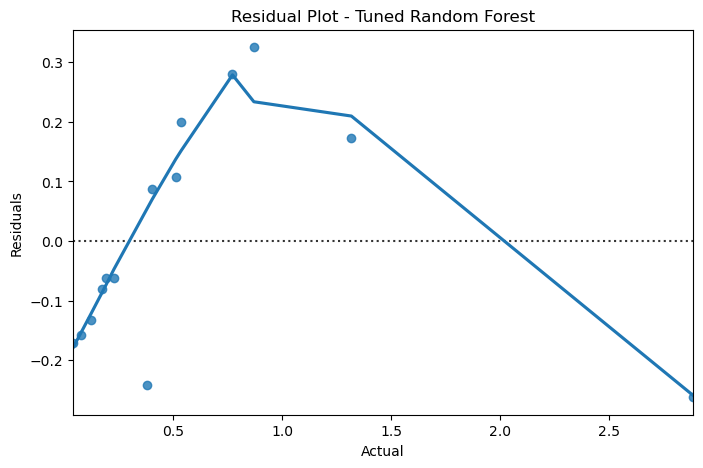

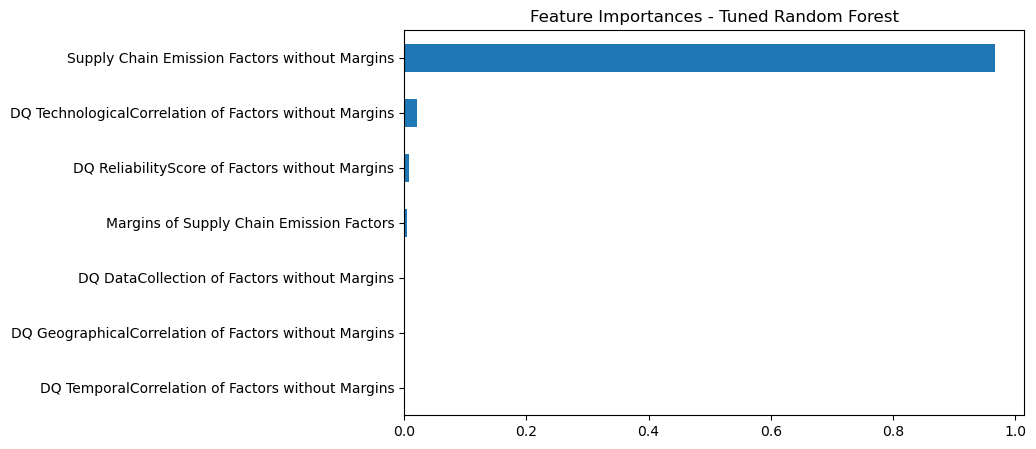

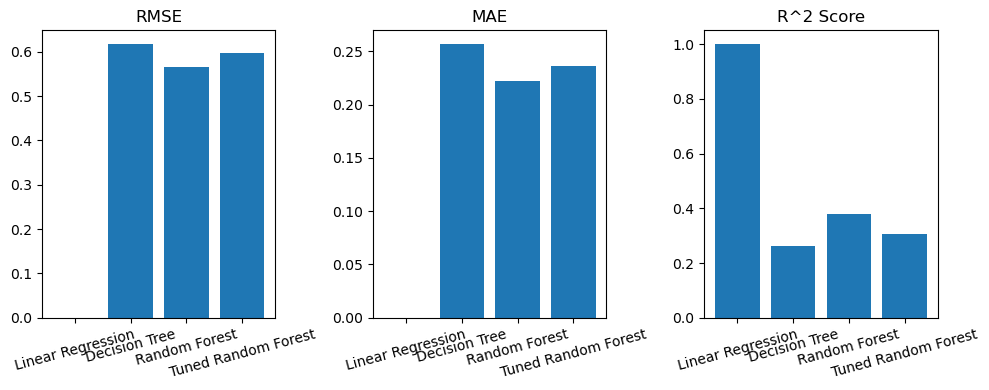

Best model saved as best_random_forest_model.pkl


In [13]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

# Load dataset
file_path = "SupplyChainEmissionFactorsforUSIndustriesCommodities (1).xlsx"
df = pd.read_excel(file_path, sheet_name="2016_Summary_Commodity")

# Filter only carbon dioxide for modeling
df = df[df['Substance'] == 'carbon dioxide']

# Select relevant features
features = [
    'Supply Chain Emission Factors without Margins',
    'Margins of Supply Chain Emission Factors',
    'DQ ReliabilityScore of Factors without Margins',
    'DQ TemporalCorrelation of Factors without Margins',
    'DQ GeographicalCorrelation of Factors without Margins',
    'DQ TechnologicalCorrelation of Factors without Margins',
    'DQ DataCollection of Factors without Margins'
]

target = 'Supply Chain Emission Factors with Margins'

X = df[features]
y = df[target]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train models
lr = LinearRegression()
dt = DecisionTreeRegressor(random_state=42)
rf = RandomForestRegressor(random_state=42)

lr.fit(X_train, y_train)
dt.fit(X_train, y_train)
rf.fit(X_train, y_train)

# Evaluate function
def evaluate_model(name, model):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name}: RMSE={rmse:.4f}, MAE={mae:.4f}, R^2={r2:.4f}")
    return rmse, mae, r2

# Evaluation
results = {}
results['Linear Regression'] = evaluate_model("Linear Regression", lr)
results['Decision Tree'] = evaluate_model("Decision Tree", dt)
results['Random Forest'] = evaluate_model("Random Forest", rf)

# Hyperparameter tuning for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
gs = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, scoring='r2', n_jobs=-1)
gs.fit(X_train, y_train)

print("Best Random Forest Params:", gs.best_params_)
best_rf = gs.best_estimator_
results['Tuned Random Forest'] = evaluate_model("Tuned Random Forest", best_rf)

# Plot residuals
plt.figure(figsize=(8, 5))
sns.residplot(x=y_test, y=best_rf.predict(X_test), lowess=True)
plt.xlabel("Actual")
plt.ylabel("Residuals")
plt.title("Residual Plot - Tuned Random Forest")
plt.show()

# Feature importance
importances = pd.Series(best_rf.feature_importances_, index=features)
importances.sort_values().plot(kind='barh', figsize=(8, 5))
plt.title("Feature Importances - Tuned Random Forest")
plt.show()

# Model comparison plot
model_names = list(results.keys())
rmse_vals = [v[0] for v in results.values()]
mae_vals = [v[1] for v in results.values()]
r2_vals = [v[2] for v in results.values()]

plt.figure(figsize=(10, 4))
plt.subplot(1, 3, 1)
plt.bar(model_names, rmse_vals)
plt.title("RMSE")
plt.xticks(rotation=15)

plt.subplot(1, 3, 2)
plt.bar(model_names, mae_vals)
plt.title("MAE")
plt.xticks(rotation=15)

plt.subplot(1, 3, 3)
plt.bar(model_names, r2_vals)
plt.title("R^2 Score")
plt.xticks(rotation=15)

plt.tight_layout()
plt.show()

# Save the best model
joblib.dump(best_rf, "best_random_forest_model.pkl")
print("Best model saved as best_random_forest_model.pkl")
